In [2]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Veri dizinleri
train_dir = "/kaggle/input/classed-odir5k-splited-into-train-test/train"
test_dir = "/kaggle/input/classed-odir5k-splited-into-train-test/test"
img_size = (224, 224)
batch_size = 64
epochs = 100  # İlk eğitim için epoch sayısı


# Veri setlerini yükle
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',  # Etiketleri one-hot encode et
    shuffle=True,
    seed=42
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',  # Etiketleri one-hot encode et
    shuffle=False
)

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast

# Veri artırma (Data Augmentation) katmanları
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2)
])



# Veri setine artırma uygula
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

# Normalizasyon katmanı
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

# Veri setine normalizasyon uygula
train_dataset = train_dataset.map(
    lambda x, y: (preprocess_input(x), y)
)
test_dataset = test_dataset.map(
    lambda x, y: (preprocess_input(x), y)
)

# Veri setlerini performans için optimize et
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 17555 files belonging to 8 classes.
Found 4392 files belonging to 8 classes.


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tensorflow.keras.optimizers import Adam

# Ortak giriş verisi
input_tensor = Input(shape=(224, 224, 3))

# EfficientNetB0 tabanlı model
efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_tensor)
efficientnet_output = GlobalAveragePooling2D()(efficientnet_base.output)

# ResNet50 tabanlı model
resnet_base = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
resnet_output = GlobalAveragePooling2D()(resnet_base.output)

# Özelliklerin birleştirilmesi
combined = concatenate([efficientnet_output, resnet_output])

# Fully connected katmanlar
x = Dense(256, activation='relu')(combined)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(8, activation='softmax')(x)

# Model oluşturma
model = Model(inputs=input_tensor, outputs=output)


# Modeli derle
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('efficientnetb0_resnet50_model.keras', save_best_only=True, monitor='val_accuracy')

# İlk eğitim (transfer öğrenme)
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping, model_checkpoint]
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 521s 1s/step - accuracy: 0.7698 - loss: 0.7069 - val_accuracy: 0.6193 - val_loss: 2.9493
Epoch 2/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 249s 904ms/step - accuracy: 0.8579 - loss: 0.4107 - val_accuracy: 0.8222 - val_loss: 0.7167
Epoch 3/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 250s 906ms/step - accuracy: 0.8672 - loss: 0.3835 - val_accuracy: 0.8522 - val_loss: 0.4213
Epoch 4/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 251s 909ms/step - accuracy: 0.8744 - loss: 0.3489 - val_accuracy: 0.8684 - val_loss: 0.3596
Epoch 5/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 247s 895ms/step - accuracy: 0.8775 - loss: 0.3419 - val_accuracy: 0.7498 - val_loss: 0.6570
Epoch 6/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 250s 907ms/step - accuracy: 0.8791 - loss: 0.3407 - val_accuracy: 0.8818 - val_loss: 0.3462
Epoch 7/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 249s 905ms/step - accuracy: 0.8749 - loss: 0.3696 - val_accura

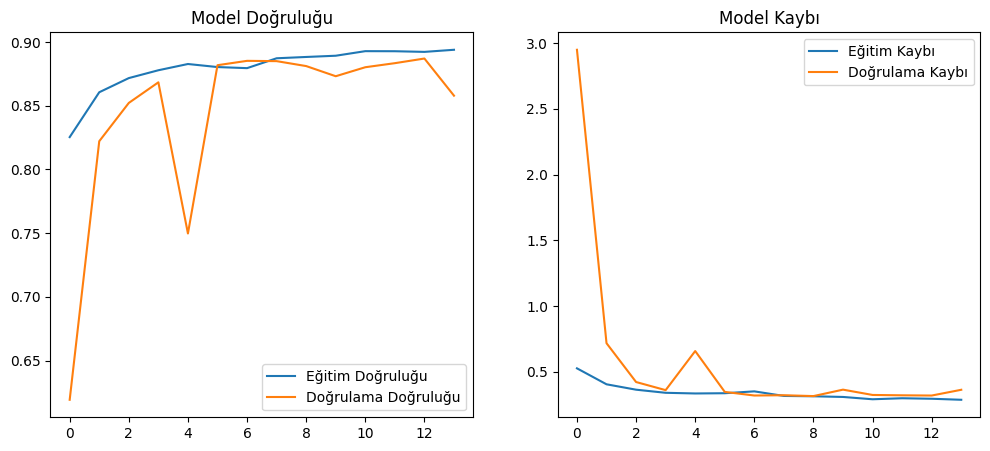

✅ Model başarıyla eğitildi ve kaydedildi!


In [4]:
# Sonuçları görselleştir
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.legend()

plt.show()

# Modeli kaydet
model.save('hybrid_model.h5')
print("✅ Model başarıyla eğitildi ve kaydedildi!")

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Test veri kümesini tahmin et
true_labels = []
predicted_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)
    predicted_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)

    predicted_labels.extend(predicted_classes)
    true_labels.extend(true_classes)

# Performans raporu
unique_classes = sorted(set(true_labels + predicted_labels))
target_names = [str(cls) for cls in unique_classes]
report = classification_report(true_labels, predicted_labels, target_names=target_names)
print("Classification Report:\n", report)

# Confusion matrix
cmp = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n",cmp)


2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━

Attention

In [9]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Veri dizinleri
train_dir = "/kaggle/input/classed-odir5k-splited-into-train-test/train"
test_dir = "/kaggle/input/classed-odir5k-splited-into-train-test/test"
img_size = (224, 224)
batch_size = 32
epochs = 100  # İlk eğitim için epoch sayısı


# Veri setlerini yükle
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',  # Etiketleri one-hot encode et
    shuffle=True,
    seed=42
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',  # Etiketleri one-hot encode et
    shuffle=False
)

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast

# Veri artırma (Data Augmentation) katmanları
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2)
])



# Veri setine artırma uygula
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

# Normalizasyon katmanı
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

# Veri setine normalizasyon uygula
train_dataset = train_dataset.map(
    lambda x, y: (preprocess_input(x), y)
)
test_dataset = test_dataset.map(
    lambda x, y: (preprocess_input(x), y)
)

# Veri setlerini performans için optimize et
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 17555 files belonging to 8 classes.
Found 4392 files belonging to 8 classes.


In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, concatenate, Multiply, Conv2D, Activation, Reshape, Lambda, Add
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Channel Attention Mekanizması
def channel_attention(input_feature, ratio=8):
    channel = input_feature.shape[-1]
    
    shared_layer_one = Dense(channel // ratio, activation='relu', use_bias=False)
    shared_layer_two = Dense(channel, use_bias=False)
    
    # Ortalama havuzlama
    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)
    
    # Maksimum havuzlama (TensorFlow işlemi yerine Lambda katmanı kullanıldı)
    max_pool = Lambda(lambda x: tf.reduce_max(x, axis=[1, 2], keepdims=True))(input_feature)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)
    
    # İki çıktıyı toplama ve sigmoid aktivasyonu
    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)
    
    return Multiply()([input_feature, cbam_feature])

# Spatial Attention Mekanizması
def spatial_attention(input_feature):
    avg_pool = Lambda(lambda x: tf.reduce_mean(x, axis=3, keepdims=True))(input_feature)
    max_pool = Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=True))(input_feature)
    concat = concatenate([avg_pool, max_pool], axis=3)
    
    cbam_feature = Conv2D(1, kernel_size=7, strides=1, padding='same', activation='sigmoid')(concat)
    
    return Multiply()([input_feature, cbam_feature])

# Ortak giriş verisi
input_tensor = Input(shape=(224, 224, 3))

# EfficientNetB0 tabanlı model
efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_tensor)
efficientnet_output = efficientnet_base.output

# EfficientNetB0 çıkışına Channel ve Spatial Attention ekle
efficientnet_output = channel_attention(efficientnet_output)
efficientnet_output = spatial_attention(efficientnet_output)
efficientnet_output = GlobalAveragePooling2D()(efficientnet_output)

# ResNet50 tabanlı model
resnet_base = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
resnet_output = resnet_base.output

# ResNet50 çıkışına Channel ve Spatial Attention ekle
resnet_output = channel_attention(resnet_output)
resnet_output = spatial_attention(resnet_output)
resnet_output = GlobalAveragePooling2D()(resnet_output)

# Özelliklerin birleştirilmesi
combined = concatenate([efficientnet_output, resnet_output])

# Fully connected katmanlar
x = Dense(256, activation='relu')(combined)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(8, activation='softmax')(x)

# Model oluşturma
model = Model(inputs=input_tensor, outputs=output)

# Modeli derle
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('efficientnetb0_resnet50_cbam_model.keras', save_best_only=True, monitor='val_accuracy')

# Modeli eğit
epochs = 100
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/100
549/549 ━━━━━━━━━━━━━━━━━━━━ 423s 540ms/step - accuracy: 0.7687 - loss: 0.6816 - val_accuracy: 0.8568 - val_loss: 0.4192
Epoch 2/100
549/549 ━━━━━━━━━━━━━━━━━━━━ 229s 417ms/step - accuracy: 0.8525 - loss: 0.4060 - val_accuracy: 0.8534 - val_loss: 0.3996
Epoch 3/100
549/549 ━━━━━━━━━━━━━━━━━━━━ 224s 408ms/step - accuracy: 0.8598 - loss: 0.3922 - val_accuracy: 0.8784 - val_loss: 0.3622
Epoch 4/100
549/549 ━━━━━━━━━━━━━━━━━━━━ 225s 409ms/step - accuracy: 0.8685 - loss: 0.3642 - val_accuracy: 0.8766 - val_loss: 0.3366
Epoch 5/100
549/549 ━━━━━━━━━━━━━━━━━━━━ 224s 407ms/step - accuracy: 0.8788 - loss: 0.3432 - val_accuracy: 0.8677 - val_loss: 0.3620
Epoch 6/100
549/549 ━━━━━━━━━━━━━━━━━━━━ 221s 401ms/step - accuracy: 0.8793 - loss: 0.3479 - val_accuracy: 0.8550 - val_loss: 0.3511
Epoch 7/100
549/549 ━━━━━━━━━━━━━━━━━━━━ 222s 403ms/step - accuracy: 0.8718 - loss: 0.3552 - val_accuracy: 0.8691 - val_loss: 0.3800
Epoch 8/100
549/549 ━━━━━━━━━━━━━━━━━━━━ 224s 407ms/step - accuracy: 

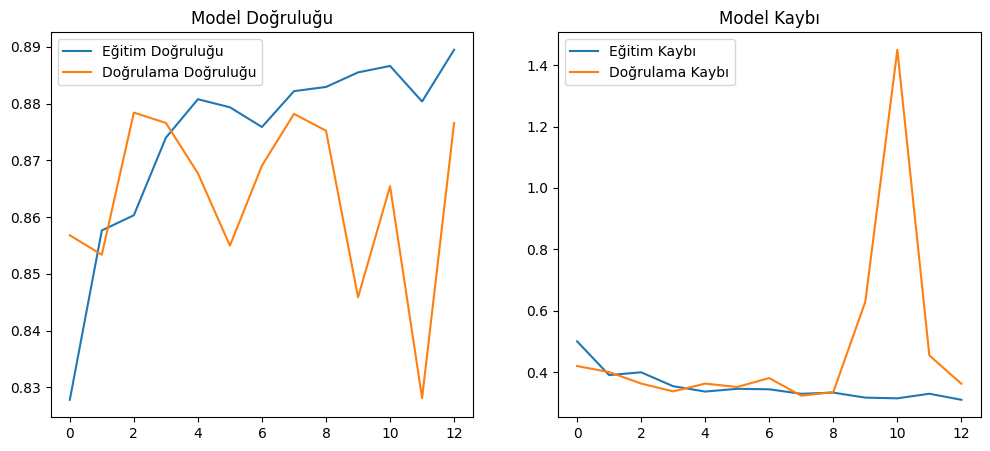

✅ Model başarıyla eğitildi ve kaydedildi!


In [12]:
# Sonuçları görselleştir
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.legend()

plt.show()

# Modeli kaydet
model.save('hybrid_attention_model.h5')
print("✅ Model başarıyla eğitildi ve kaydedildi!")

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Test veri kümesini tahmin et
true_labels = []
predicted_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)
    predicted_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)

    predicted_labels.extend(predicted_classes)
    true_labels.extend(true_classes)

# Performans raporu
unique_classes = sorted(set(true_labels + predicted_labels))
target_names = [str(cls) for cls in unique_classes]
report = classification_report(true_labels, predicted_labels, target_names=target_names)
print("Classification Report:\n", report)

# Confusion matrix
cmp = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", cmp)


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━